### Using Image augmentation to improve performance on image classifier

The dataset comprises 100 food categories, each with ~1000 images. I will initially run a ResNet style model and get a benchmark for classification.

I will then use image augmentation, cropping and mirroring the images to increase the size of the training set to see if this increases performance

In [10]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import plotly
import plotly.graph_objects as go
import plotly.express as px
import datetime
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models, Model, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, Flatten, Dense, Activation, Add
import matplotlib.pyplot as plt
from tensorflow.keras import activations
import os

#### Loading the images

The images are a range of sizes, and we'll handle this by converting them all to 128x128, padding the outside where necessary

In [8]:
#Open image into an 'image' object type
def image_to_vector(file):
    im_vec = (Image.open(file))
    #calculate height and width
    width = (im_vec.size[0])
    height = im_vec.size[1]
    #re-size to 1/4 of the size and convert to an array - we've already shown that this doesn't decrease performance
    im_vec = np.array(im_vec.resize((int(width/4),int(height/4))))
    #Pad it out to a full 128 by 128
    hor_pad_1 = int((128-im_vec.shape[0])/2)
    hor_pad_2 = int((128-im_vec.shape[0]+1)/2)
    ver_pad_1 = int((128 - im_vec.shape[1])/2)
    ver_pad_2 = int((128 - im_vec.shape[1]+1)/2)
    im_vec = np.pad(im_vec,pad_width=((hor_pad_1,hor_pad_2),(ver_pad_1,ver_pad_2),(0,0)))
    return im_vec
sampe_file = '/Users/jacoblourie/Downloads/Food_Images/Images/foie_gras/59910.jpg'
im_vec = image_to_vector(sampe_file)

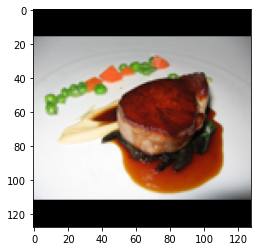

In [7]:
plt.imshow(im_vec); plt.show()

##### We will work with only the opening 20 food categories

In [24]:
'''Load in images of food'''

#go through all the images, put them into vector form, and then have a dictionary where each key is a type of image, and the value is a list of all those vectors.
list_of_food = []
unique_foods = {}
x = np.zeros((20000,128,128,3)).astype(np.uint8)
counter_cats, counter =0,0
for food_cat in os.listdir('/Users/jacoblourie/Downloads/Food_Images/Images')[0:21]:
    
    if (food_cat == '.DS_Store') or (food_cat == 'waffles'):
        continue
    unique_foods[counter_cats]=food_cat
    # examples = len(os.listdir(f'/Users/jacoblourie/Downloads/Food_Images/Images/{food_cat}'))   
    
    for file in os.listdir(f'/Users/jacoblourie/Downloads/Food_Images/Images/{food_cat}'):
        file_ = f'/Users/jacoblourie/Downloads/Food_Images/Images/{food_cat}/{file}'
        
        #here we are resizing
        try:
            im_vec = image_to_vector(file_)
            x[counter] = im_vec.astype(np.uint8)
            # plt.imshow(im_vec)
            list_of_food.append(food_cat)
            counter+=1
        except:
          print(f'{food_cat} had an error')


    counter_cats+=1

steak had an error


#### Creating Y labels and preprocessing the data

In [16]:
#get list of each value in a series with value counts
df = pd.DataFrame(pd.Series(list_of_food).value_counts())
#initialise blank array
y=np.array([])
for food_idx, food in unique_foods.items():
    length =  df.loc[food]
    y  = np.append(y, np.zeros(length)+food_idx)
print(f'Y has {len(y)} numbers')
display(df.T)

Y has 18999 numbers


,french_toast,shrimp_and_grits,ice_cream,cheesecake,chicken_curry,gnocchi,samosa,filet_mignon,seaweed_salad,tuna_tartare,churros,cheese_plate,cup_cakes,red_velvet_cake,club_sandwich,garlic_bread,donuts,foie_gras,steak
0,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,999


There are only 999 images of steak (it's likely that one image was defective. I will crop X off after 18999

In [26]:
#ensure parallel sizes
x, y = x[:18999], y[:18999]

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

#normalise x values
x_train, x_test = x_train/255, x_test/255
one_hot = OneHotEncoder(sparse = False)

#create one hot values for y, and reshape to an array
one_hot_y_train= one_hot.fit_transform(y_train.reshape(-1,1))
one_hot_y_test= one_hot.fit_transform(y_test.reshape(-1,1))

### Base Case ResNet

Initially, I will run a resnet model with 10 resnet layers, which has previously achieved 90% classification on a validation set of 12500 cat/dog images

In [50]:
class ResNet_20_3():
    #By creating a subclass, we don't need to repeat the train_val_rpedict
    
    #Initialise with the input shape(ignoring examples) and output shape
    def __init__(self, input_dims, output='softmax', classes='False',conv_k_reg=0.001,conv_b_reg=0.001,dense_k_reg=0.001,dense_b_reg=0.001,name='ResNet_512_512_3'): 
        
        #Set regularisers
        self.conv_k_reg = tf.keras.regularizers.L2(conv_k_reg)
        self.conv_b_reg = tf.keras.regularizers.L2(conv_b_reg)
        self.dense_k_reg = tf.keras.regularizers.L2(dense_k_reg)
        self.dense_b_reg = tf.keras.regularizers.L2(dense_b_reg)

        self.input_im = Input(shape=(input_dims))
        
        #start with a layer non resnet
        x = Conv2D(196,kernel_size=(5,5),padding='same',strides=(2,2), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(self.input_im)
        x = Activation(activations.relu)(x)
        x = MaxPool2D(pool_size=(3,3),padding='valid',strides=(2,2))(x)
        #2 non pool ones
        for i in range(3):
            x = self._resnet_layer(x,second_kernel=(5,5))
        x = MaxPool2D(pool_size=(4,4),padding='valid',strides=(2,2))(x)    
        for i in range(2):
            x = self._resnet_layer(x,second_kernel=(7,7))
        for i in range(2):
            x = self._resnet_layer(x,second_kernel=(5,5))

        x = MaxPool2D(pool_size=(3,3),padding='valid',strides=(1,1))(x)
        for i in range(1):
            x = self._resnet_layer(x,second_kernel=(3,3),filters=(64,512))
        x = MaxPool2D(pool_size=(2,2),padding='valid',strides=(2,2))(x)
        x = Flatten()(x)
        x = Dense(190,activation='relu',kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        x = Dense(190,activation='relu',kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        activation = output
        if output == 'sigmoid':
            classes = 1
        x = Dense(classes, activation=activation,kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.dense_k_reg,bias_regularizer=self.dense_b_reg)(x)
        self.model = Model(inputs = self.input_im, outputs= x,name=name)



    def _resnet_layer(self,x, second_kernel=(3,3), filters=(32,128)):
        f1,f2=filters
        #do one full layer convolution, with activation
        x_skip = x
        #do another 2 layers for the x that you're passing through the longer loops
        x = Conv2D(f1, kernel_size=(1,1),activation='relu',padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)
        x = Conv2D(f2, kernel_size=second_kernel,activation='relu',padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x)        
        #conv the skip
        x_ = Conv2D(f2, kernel_size=(1,1),padding='same',strides=(1,1), kernel_initializer='he_normal',bias_initializer='he_normal',kernel_regularizer=self.conv_k_reg,bias_regularizer=self.conv_b_reg)(x_skip)
        
        #add them back to together
        x = Add()([x,x_])
        #activation both of them
        x = Activation(activations.relu)(x)        
        return x
    
    def train_test_predict(self,x_train,y_train,x_test,y_test):
        preds_train  = np.argmax(self.model.predict(x_train),axis=-1)
        preds_test = np.argmax(self.model.predict(x_test),axis=-1)
        self.current_train_prediction_score = {np.sum(y_train - preds_train == 0)/x_train.shape[0]}
        self.current_test_prediction_score = {np.sum(y_test - preds_test == 0)/x_test.shape[0]}
        print(f'train prediction percentage is {self.current_train_prediction_score}')
        print(f'test prediction percentage is {self.current_test_prediction_score}')

'''Other helper functions'''
#Plotting the accuracy of a second val set, and the historic performance of the validations et.
def plot_accs(training_object):
    val_acc, train_acc = training_object.history['val_acc'], training_object.history['acc']
    x = np.linspace(1,len(val_acc),len(val_acc))
    fig = plt.figure()
    plt.scatter(x,val_acc,) #= go.Scatter(x=x,y=val_acc,name='val_acc'), 
    plt.scatter(x=x,y=train_acc) # ,name='train_acc')
    plt.legend(('val_acc','train_acc'))
    #     fig.add_trace(line_1)
#     fig.add_trace(line_2)
    fig.show()

In [40]:
resnet_20 = ResNet_20_3((128,128,3),classes=19)

In [43]:
resnet_20.model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='acc')
resnet_20.model.summary()

Model: "ResNet_512_512_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_143 (Conv2D)             (None, 64, 64, 196)  14896       input_6[0][0]                    
__________________________________________________________________________________________________
activation_51 (Activation)      (None, 64, 64, 196)  0           conv2d_143[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 31, 31, 196)  0           activation_51[0][0]              
___________________________________________________________________________________

<ipython-input-50-8b173efed264>:78: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



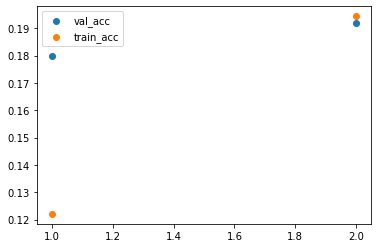

In [51]:
# #fit the mdoel
training_object = resnet_20.model.fit(x_train,one_hot_y_train,epochs=2,batch_size=20, validation_split = 0.2,validation_batch_size=200)
#final prediction
resnet_20.train_test_predict(x_train,y_train,x_test[:5000],y_test[:5000])
plot_accs(training_object)

In [52]:
#re run after we have confirmed it's moving in right direction

Epoch 1/4
122/122 [==============================] - 599s 5s/step - loss: 2.9900 - acc: 0.2539 - val_loss: 2.9792 - val_acc: 0.2447
Epoch 2/4
122/122 [==============================] - 574s 5s/step - loss: 2.8595 - acc: 0.2820 - val_loss: 2.8892 - val_acc: 0.2622
Epoch 3/4
122/122 [==============================] - 560s 5s/step - loss: 2.7835 - acc: 0.2934 - val_loss: 2.7903 - val_acc: 0.2839
Epoch 4/4
122/122 [==============================] - 439s 4s/step - loss: 2.7043 - acc: 0.3116 - val_loss: 2.7404 - val_acc: 0.2898
train prediction percentage is {0.3216658990723074}
test prediction percentage is {0.29210526315789476}


<ipython-input-50-8b173efed264>:78: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



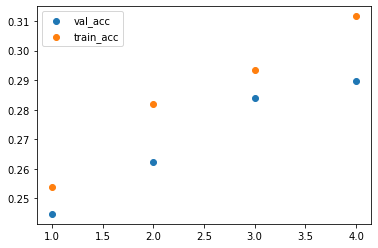

In [53]:
# #fit the mdoel
training_object = resnet_20.model.fit(x_train,one_hot_y_train,epochs=4,batch_size=100, validation_split = 0.2,validation_batch_size=500)
#final prediction
resnet_20.train_test_predict(x_train,y_train,x_test[:5000],y_test[:5000])
plot_accs(training_object)